In [1]:
!pip install tensorflow==2.0.0

In [2]:
import os
import nltk
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from matplotlib import pyplot as plt
import json
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import pandas as pd
import csv
import zipfile

Using TensorFlow backend.


In [3]:
tf.__version__

'2.0.0'

In [4]:
!wget https://storage.googleapis.com/columbia_landmarks/glove_50.zip  \
    -O /tmp/RawData1.zip

--2020-02-20 19:44:59--  https://storage.googleapis.com/columbia_landmarks/glove_50.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.124.128, 2607:f8b0:4001:c00::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.124.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 209323095 (200M) [application/zip]
Saving to: ‘/tmp/RawData1.zip’

/tmp/RawData1.zip   100%[===================>] 199.63M   119MB/s    in 1.7s    

2020-02-20 19:45:01 (119 MB/s) - ‘/tmp/RawData1.zip’ saved [209323095/209323095]



In [0]:
local_zip = '/tmp/RawData1.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [6]:
!ls -al /tmp

total 703352
drwxrwxrwt 1 root root      4096 Feb 20 19:45 .
drwxr-xr-x 1 root root      4096 Feb 20 19:40 ..
-rw-r--r-- 1 root root 510887943 Feb 20 19:45 glove.twitter.27B.50d.txt
drwxr-xr-x 2 root root      4096 Feb 20 19:45 __MACOSX
-rw-r--r-- 1 root root 209323095 Feb 20 05:05 RawData1.zip


In [7]:
embeddings_index = {}
f = open('/tmp/glove.twitter.27B.50d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 1193514 word vectors.


In [8]:
!wget https://raw.githubusercontent.com/harish-cu/tweet-url-relationships/master/data/temp/sampling_blind/latest/articles_train.csv
!wget https://raw.githubusercontent.com/harish-cu/tweet-url-relationships/master/data/temp/sampling_blind/latest/articles_test.csv

--2020-02-20 19:45:42--  https://raw.githubusercontent.com/harish-cu/tweet-url-relationships/master/data/temp/sampling_blind/latest/articles_train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6529213 (6.2M) [text/plain]
Saving to: ‘articles_train.csv’

articles_train.csv  100%[===================>]   6.23M  --.-KB/s    in 0.1s    

2020-02-20 19:45:42 (59.6 MB/s) - ‘articles_train.csv’ saved [6529213/6529213]

--2020-02-20 19:45:43--  https://raw.githubusercontent.com/harish-cu/tweet-url-relationships/master/data/temp/sampling_blind/latest/articles_test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:

In [9]:
!ls -al

total 7872
drwxr-xr-x 1 root root    4096 Feb 20 19:45 .
drwxr-xr-x 1 root root    4096 Feb 20 19:40 ..
-rw-r--r-- 1 root root 1510757 Feb 20 19:45 articles_test.csv
-rw-r--r-- 1 root root 6529213 Feb 20 19:45 articles_train.csv
drwxr-xr-x 1 root root    4096 Feb 19 17:12 .config
drwxr-xr-x 1 root root    4096 Feb  5 18:37 sample_data


In [0]:
df_train = pd.read_csv('articles_train.csv')
df_test = pd.read_csv('articles_test.csv')

In [0]:
text = df_train['content_body_clean']

In [12]:
type(text)

pandas.core.series.Series

In [0]:
t = Tokenizer()
t.fit_on_texts(text)

sequence_length = 7000


train = t.texts_to_sequences(text)
num_words = len(t.word_index)+1
max_features = num_words
x_train = pad_sequences(train, maxlen=sequence_length, padding='post')
y_train = np.array(df_train['blind_mean_rating']/5)

In [14]:
len(train)
# !wc -l articles_train.csv
# tokenized[0]

# i = len(train[0])
# for j in range(len(train)):
#   if len(train[j]) > i:
#     i = len(train[j])
#     print(i)


1301

In [0]:
y_train = np.array(df_train['blind_mean_rating']/5)

In [16]:
y_train[0]

0.6355555555555555

In [17]:
word_index = t.word_index
print('Found %s unique tokens.' % len(word_index))

Found 38128 unique tokens.


In [18]:

print(num_words)

embedding_dim = 50

# first create a matrix of zeros, this is our embedding matrix
embedding_matrix = np.zeros((num_words, embedding_dim))

# for each word in out tokenizer lets try to find that work in our w2v model
for word, i in word_index.items():
    if i > max_features:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # we found the word - add that words vector to the matrix
        embedding_matrix[i] = embedding_vector
    else:
        # doesn't exist, assign a random vector
        embedding_matrix[i] = np.random.randn(embedding_dim)

38129


In [0]:
from keras.initializers import Constant

In [20]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(num_words,
                    embedding_dim,
                    embeddings_initializer=Constant(embedding_matrix),
                    input_length=sequence_length,
                    trainable=True))
# model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.compile('adam', loss='mse')
model.summary()

# model.add(Dropout(0.25))
# model.add(Dense(units=5, activation='softmax'))
# model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
# print(model.summary())
# model = Sequential()
# model.add(Bidirectional(LSTM(20, return_sequences=True), input_shape=(n_timesteps, 1)))
# model.add(TimeDistributed(Dense(1, activation='sigmoid')))
# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# # train LSTM

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 7000, 50)          1906450   
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               58880     
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 1,973,651
Trainable params: 1,973,651
Non-trainable params: 0
_________________________________________________________________


In [21]:
history = model.fit(x_train, y_train, epochs=6, validation_split=0.2)

Train on 1040 samples, validate on 261 samples
Epoch 1/6
1040/1040 [==============================] - 463s 446ms/sample - loss: 0.0310 - val_loss: 0.0382
Epoch 2/6
1040/1040 [==============================] - 452s 435ms/sample - loss: 0.0282 - val_loss: 0.0376
Epoch 3/6
1040/1040 [==============================] - 453s 435ms/sample - loss: 0.0261 - val_loss: 0.0388
Epoch 4/6
1040/1040 [==============================] - 449s 432ms/sample - loss: 0.0249 - val_loss: 0.0386
Epoch 5/6
1040/1040 [==============================] - 460s 443ms/sample - loss: 0.0204 - val_loss: 0.0380
Epoch 6/6
1040/1040 [==============================] - 464s 446ms/sample - loss: 0.0173 - val_loss: 0.0415


In [0]:
test = t.texts_to_sequences(df_test['content_body_clean'])
x_test = pad_sequences(test, maxlen=sequence_length, padding='post')
y_test = np.array(df_test['blind_mean_rating']/5)

In [23]:
loss = model.evaluate(x_test, y_test)
print('Model Test Loss: {0:.4f}'.format(loss))

326/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

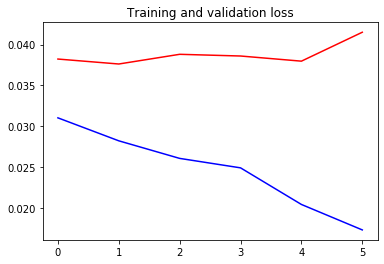

In [27]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b')
plt.plot(epochs, val_loss, 'r')
plt.title('Training and validation loss')
plt.show()

In [0]:
y_pred = model.predict(x_test)

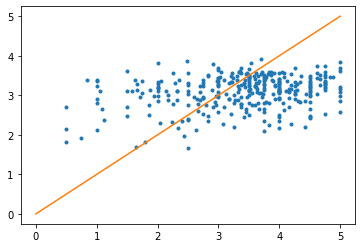

In [29]:
### Fit on test data
y_pred = model.predict(x_test) 
plt.plot(y_test*5, y_pred*5, '.')

# # plot a line, a perfit predict would all fall on this line
x = np.linspace(0, 5)
y = x
plt.plot(x, y)
plt.show()

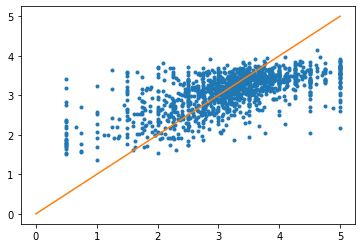

In [30]:
### Fit on training data

y_pred = model.predict(x_train) 
plt.plot(y_train*5, y_pred*5, '.')

# # plot a line, a perfit predict would all fall on this line
x = np.linspace(0, 5)
y = x
plt.plot(x, y)
plt.show()